In [ ]:
import tsplib95
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [16]:
def load_tsp_file_with_txt(file_path):
    problem = tsplib95.load(file_path)
    
    # get node coordinates
    coordinates = []
    for node in problem.get_nodes():
        coord = problem.node_coords[node]
        coordinates.append((coord[0], coord[1]))
    
    return np.array(coordinates)

# Load the data
cities = load_tsp_file_with_txt('eil51.txt')
print(np.shape(cities))
print("Loaded Cities' Coordinates:")
print(cities)


(51, 2)
Loaded Cities' Coordinates:
[[37 52]
 [49 49]
 [52 64]
 [20 26]
 [40 30]
 [21 47]
 [17 63]
 [31 62]
 [52 33]
 [51 21]
 [42 41]
 [31 32]
 [ 5 25]
 [12 42]
 [36 16]
 [52 41]
 [27 23]
 [17 33]
 [13 13]
 [57 58]
 [62 42]
 [42 57]
 [16 57]
 [ 8 52]
 [ 7 38]
 [27 68]
 [30 48]
 [43 67]
 [58 48]
 [58 27]
 [37 69]
 [38 46]
 [46 10]
 [61 33]
 [62 63]
 [63 69]
 [32 22]
 [45 35]
 [59 15]
 [ 5  6]
 [10 17]
 [21 10]
 [ 5 64]
 [30 15]
 [39 10]
 [32 39]
 [25 32]
 [25 55]
 [48 28]
 [56 37]
 [30 40]]


In [ ]:
def euclidean_distance(city1, city2):
    return np.linalg.norm(city1 - city2)

def compute_distance_matrix(cities):
    """Computes distance between two cities 
    Returns: Distance matrix 
    """
    num_cities = len(cities)
    dist_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                dist_matrix[i][j] = euclidean_distance(cities[i], cities[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(cities)

def calculate_total_distance(tour, dist_matrix):
    """Calculate total distance of one tour (defined as array of cities)"""
    total_distance = 0
    num_cities = len(tour)
    for i in range(num_cities):
        total_distance += dist_matrix[tour[i]][tour[(i + 1) % num_cities]]
    return total_distance

def generate_initial_solution(num_cities):
    """Initialize a random tour"""
    tour = list(range(num_cities))
    random.shuffle(tour)
    return tour


initial_tour = generate_initial_solution(len(cities))
print("Initial Tour:", initial_tour)
print("Initial Distance:", calculate_total_distance(initial_tour, distance_matrix))



Initial Tour: [6, 24, 4, 29, 23, 1, 22, 3, 26, 25, 41, 38, 49, 47, 16, 37, 21, 35, 43, 39, 20, 7, 2, 45, 32, 31, 36, 13, 17, 18, 15, 5, 9, 34, 40, 42, 28, 8, 11, 14, 0, 19, 27, 48, 50, 33, 44, 12, 10, 30, 46]
Initial Distance: 1704.2124682861988


In [ ]:
def two_opt_swap(tour, i, k):
    """Swap two cities in a tour"""
    new_tour = tour[:i] + tour[i:k + 1][::-1] + tour[k + 1:]
    return new_tour

def simulated_annealing(cities, initial_temperature, cooling_rate, max_iterations, markov_length):
    """Simulated annealing of travlling salesman
    
    Input: 
    cities (shape=(n,2) np.array) : coordinates of cities
    initial_temperature (float)
    cooling_rate: rate [0,1] of cooling per simulation step (slow cooling > 1, better result but slower)
    max_iterations: number of cooling steps
    markov_length: number of candidate solutions generated and evaluated at each temperature step
    
    Return:
    
    """
    num_cities = len(cities)
    dist_matrix = compute_distance_matrix(cities)
    # Generate random tour
    current_solution = generate_initial_solution(num_cities)
    current_distance = calculate_total_distance(current_solution, dist_matrix)
    best_solution = current_solution
    best_distance = current_distance
    
    temperature = initial_temperature


    for iteration in range(max_iterations):
        for _ in range(markov_length):
            # Generate a new solution with a 2-opt move
            i, k = sorted(random.sample(range(num_cities), 2))
            new_solution = two_opt_swap(current_solution, i, k)
            new_distance = calculate_total_distance(new_solution, dist_matrix)
            
            # Calculate the change in distance
            delta = new_distance - current_distance

            # Accept the new solution based on the acceptance probability
            if delta < 0 or random.random() < math.exp(-delta / temperature):
                current_solution = new_solution
                current_distance = new_distance

                # Update the best solution if needed
                if current_distance < best_distance:
                    best_solution = current_solution
                    best_distance = current_distance

        # Cool down the temperature
        temperature *= cooling_rate

        # Optional: Print progress
        print(f"Iteration {iteration + 1}, Temperature: {temperature:.2f}, Best Distance: {best_distance:.2f}")

    return best_solution, best_distance


In [17]:
best_tour, best_distance = simulated_annealing(
    cities=cities,
    initial_temperature=1000,
    cooling_rate=0.999,
    max_iterations=5000,
    markov_length=100
)

print("Best Tour:", best_tour)
print("Best Distance:", best_distance)


Iteration 1, Temperature: 999.00, Best Distance: 1470.95
Iteration 2, Temperature: 998.00, Best Distance: 1470.95
Iteration 3, Temperature: 997.00, Best Distance: 1470.95
Iteration 4, Temperature: 996.01, Best Distance: 1470.95
Iteration 5, Temperature: 995.01, Best Distance: 1470.95
Iteration 6, Temperature: 994.01, Best Distance: 1470.95
Iteration 7, Temperature: 993.02, Best Distance: 1470.95
Iteration 8, Temperature: 992.03, Best Distance: 1470.95
Iteration 9, Temperature: 991.04, Best Distance: 1470.95
Iteration 10, Temperature: 990.04, Best Distance: 1450.89
Iteration 11, Temperature: 989.05, Best Distance: 1450.89
Iteration 12, Temperature: 988.07, Best Distance: 1450.89
Iteration 13, Temperature: 987.08, Best Distance: 1450.89
Iteration 14, Temperature: 986.09, Best Distance: 1411.20
Iteration 15, Temperature: 985.10, Best Distance: 1411.20
Iteration 16, Temperature: 984.12, Best Distance: 1411.20
Iteration 17, Temperature: 983.14, Best Distance: 1411.20
Iteration 18, Temperatu

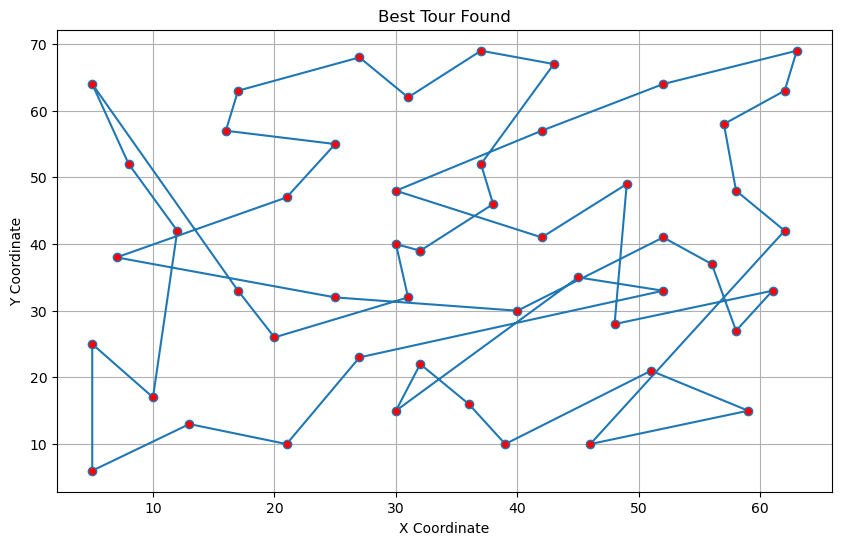

In [18]:
def plot_tour(cities, tour):
    tour_cities = cities[tour + [tour[0]]]  # Complete the loop
    plt.figure(figsize=(10, 6))
    plt.plot(tour_cities[:, 0], tour_cities[:, 1], 'o-', markerfacecolor='red')
    plt.title("Best Tour Found")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

plot_tour(cities, best_tour)
